In [1]:
import numpy as np
from scipy.io import loadmat
from time import time
from tqdm import tqdm

from src.models.model import Model
from src.layers.linear import Linear
from src.neuron_models.lif import LIF
from src.util.DataLoader import DataLoader
from src.util.Transforms import Scale
from src.util.scheduler import Scheduler
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 25})

np.random.seed(1234)

In [2]:
#We are experimenting with 8 learning rate functions
epochs = 10
fixed,exp,inv,poly,sin,sin2,sinexp,tri2 = (np.ones(epochs) for _ in range(8)) # generator expression
fixed = 0.01*fixed
for i in range(epochs):
    exp[i] = 0.01*(np.power(0.9,i))+0.01
    inv[i] = 0.01*(1/(np.power((1+(i*(0.0001))),0.75)))+0.01
    poly[i] = 0.01*(np.power(1-(i/10),1.2))+0.01
    sin[i] = np.abs(0.01-0)*np.abs(np.sin(np.pi*(i/(2*2.5)))) + min(0.01,0)
    sin2[i] = np.abs(0.01-0)*(1/(np.power(2,np.floor(i/(2*2.5)))))*np.abs(np.sin(np.pi*(i/(2*2.5)))) + min(0.01,0)
    sinexp[i] = 0.01*np.abs(np.sin(np.pi*(i/5)))*np.power(0.9,i) + 0.01
    tri2[i] = 0.01*(2/np.pi)*np.abs(np.arcsin(np.sin(np.pi*(i/5)))) + 0.01

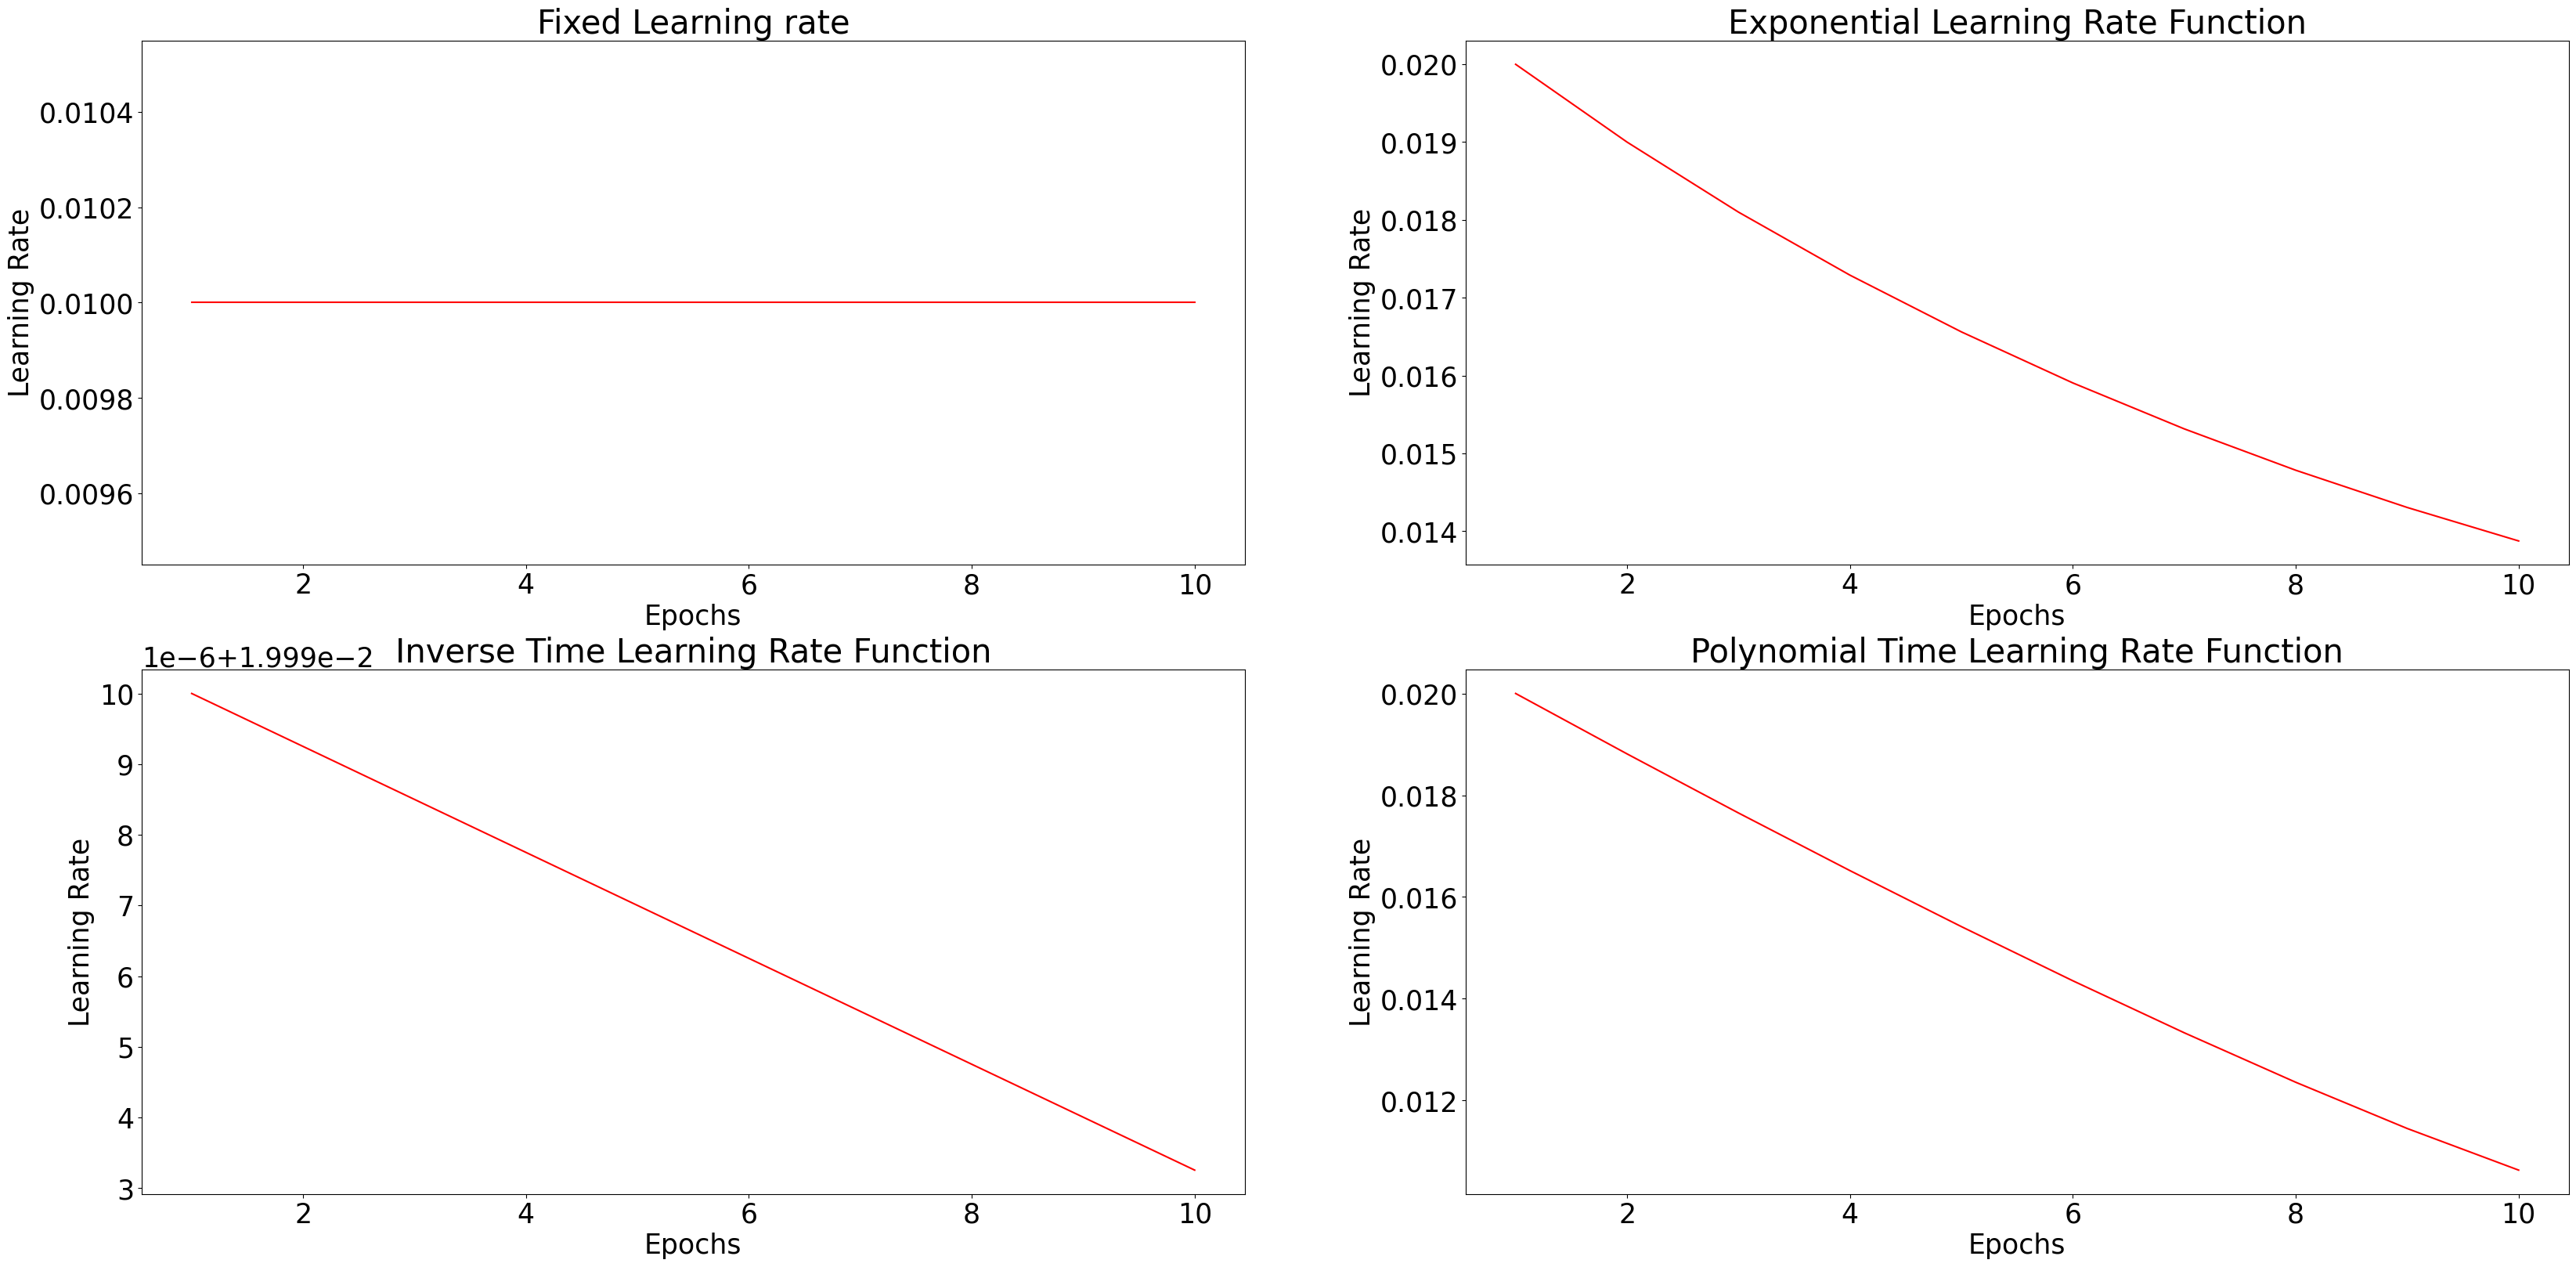

In [4]:
#PLotting  Learning Rate Functions
epochs_range =  np.arange(1,11)
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(40, 40))
plt.subplot(4, 2, 1)
plt.plot(epochs_range,fixed,'r')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.title('Fixed Learning rate')

plt.subplot(4, 2, 2)
plt.plot(epochs_range,exp,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.title('Exponential Learning Rate Function')

plt.subplot(4, 2, 3)
plt.plot(epochs_range,inv,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.title('Inverse Time Learning Rate Function')

plt.subplot(4, 2, 4)
plt.plot(epochs_range,poly,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.title('Polynomial Time Learning Rate Function')
plt.show()


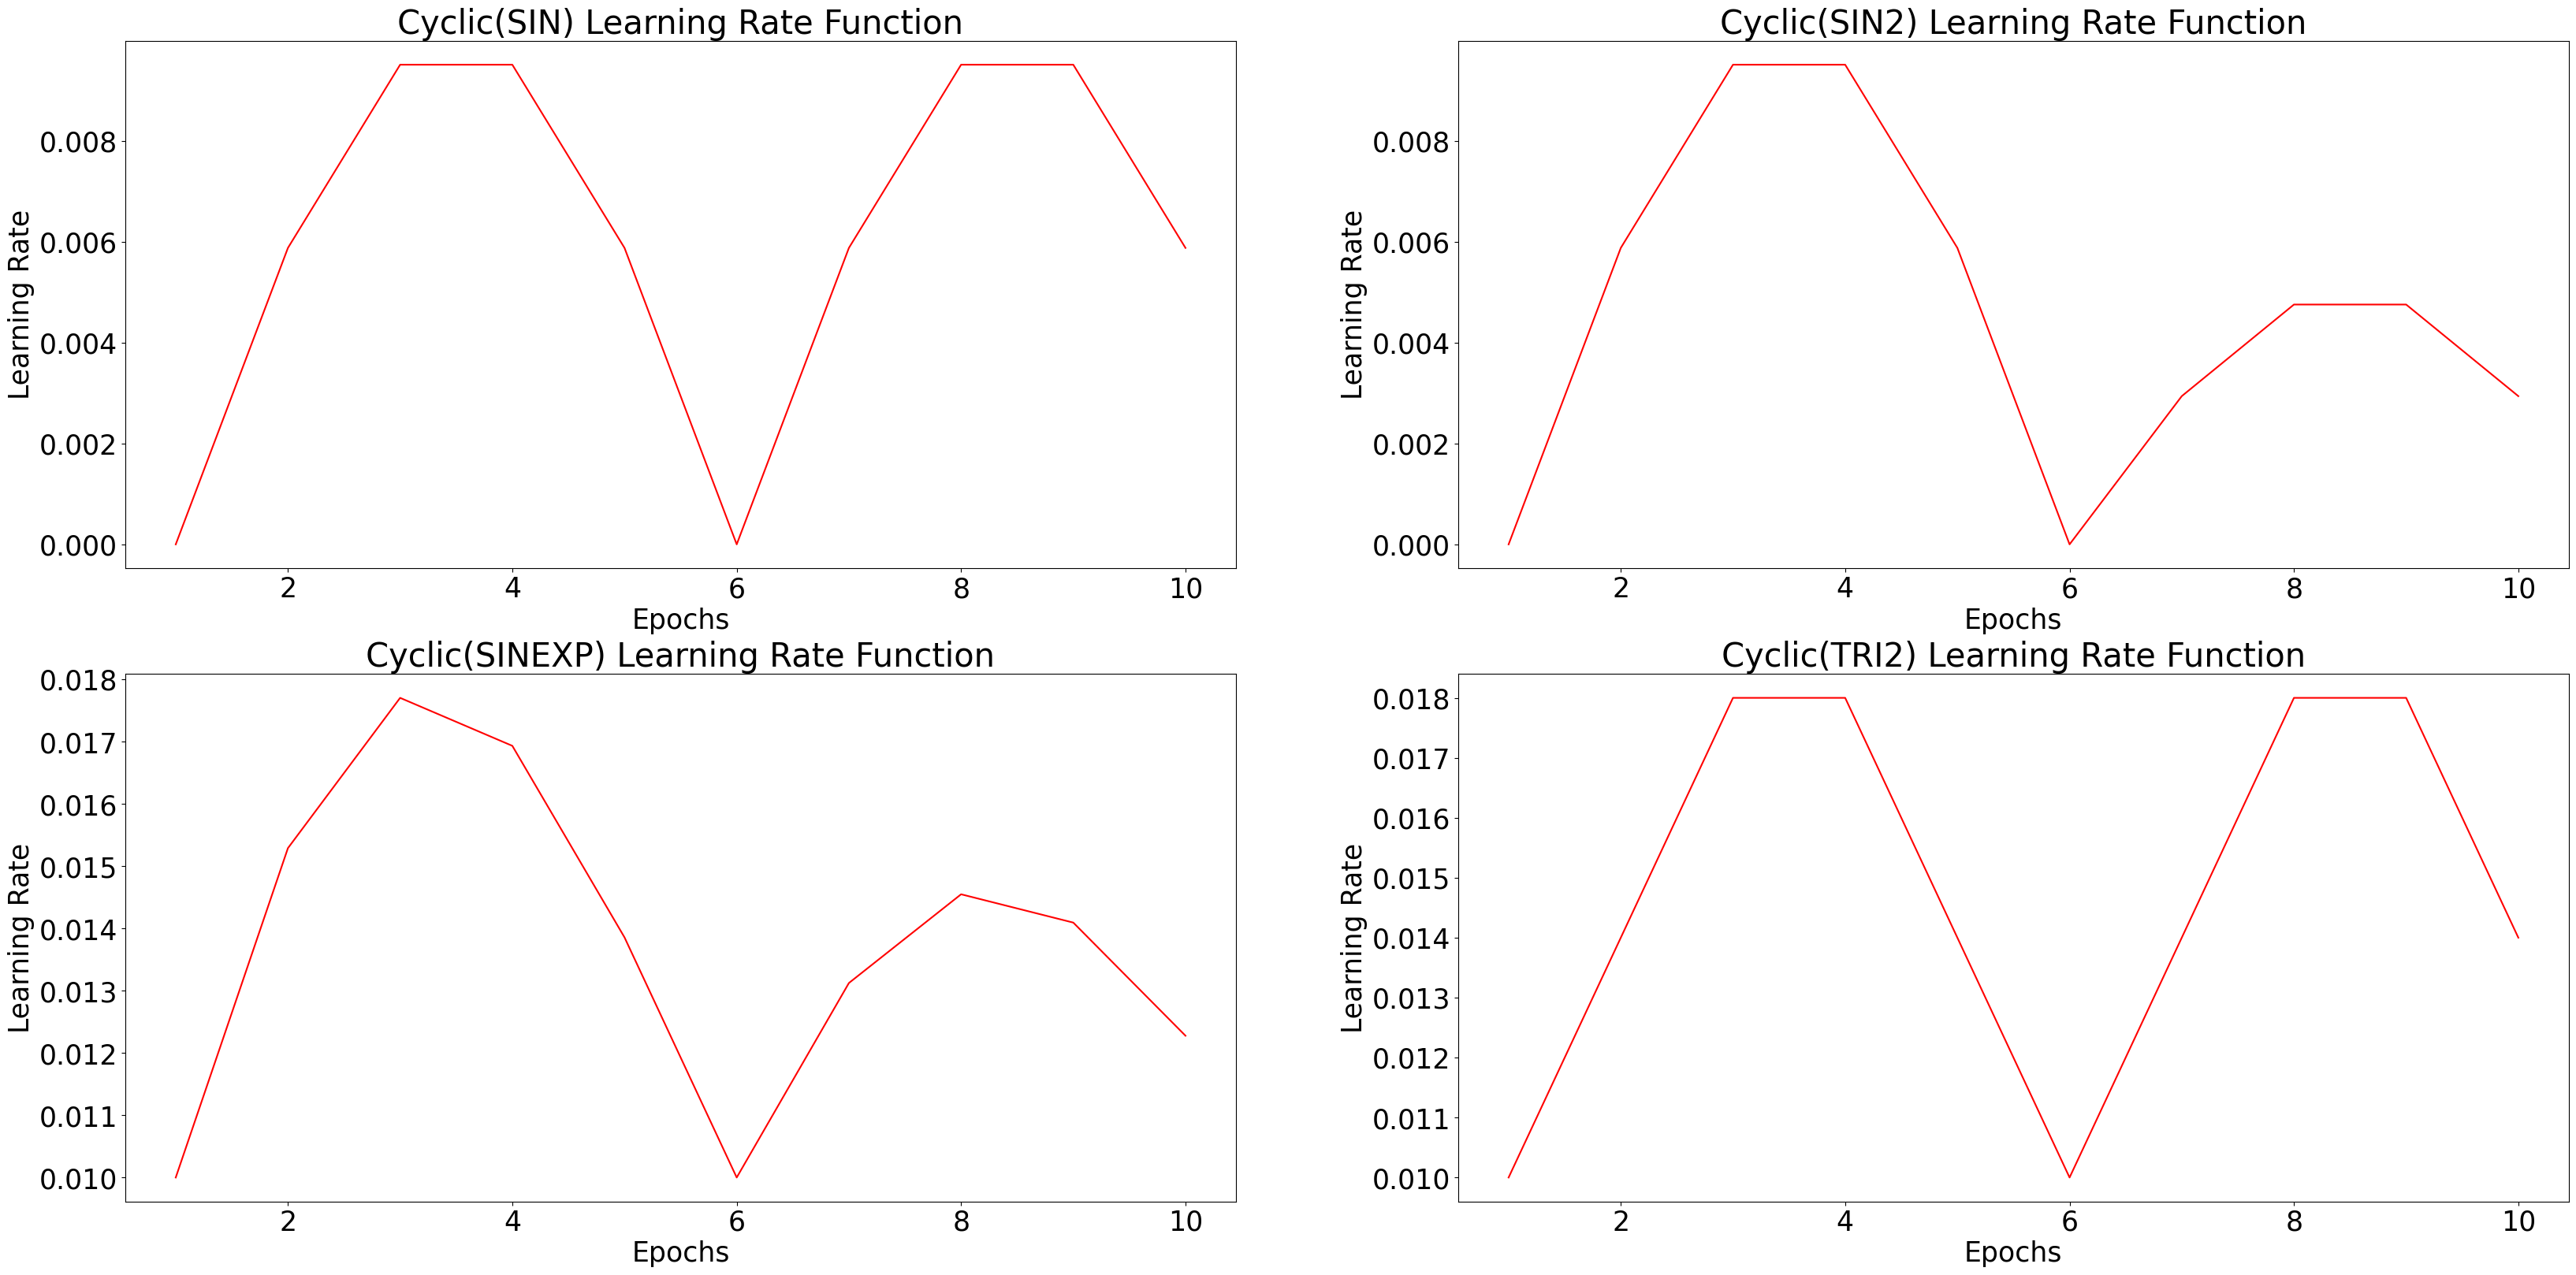

In [5]:
#PLotting Cyclic Learning Rate Functions
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(40, 40))
plt.subplot(4, 2, 1)
plt.plot(epochs_range,sin,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.title('Cyclic(SIN) Learning Rate Function')

plt.subplot(4, 2, 2)
plt.plot(epochs_range,sin2,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Cyclic(SIN2) Learning Rate Function')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")

plt.subplot(4, 2, 3)
plt.plot(epochs_range,sinexp,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Cyclic(SINEXP) Learning Rate Function')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")


plt.subplot(4, 2, 4)
plt.plot(epochs_range,tri2,'r')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Cyclic(TRI2) Learning Rate Function')
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.show()

In [6]:
#------------------------------------------
#Your design parameters go here onwards
#------------------------------------------
##### Declare parameters here
batch_size = 1
Learning_time=10
Evaluation_time=5
epochs = 10
lr_functions = [sin]
functions = ['sin']
#lr_scheduler = Scheduler(lr_vector)

In [7]:
##### Network architecture for a 784-256-10 fully connected network
print("==> Building Models")
#Creating 4 Different Models
models  = []
for i in range(len(lr_functions)):
    snn_model = Model()
    snn_model.add(Linear(256, 784, neuron_model=LIF))
    snn_model.add(Linear(256, 256, neuron_model=LIF))
    snn_model.add(Linear(10,  256, neuron_model=LIF))
    models.append(snn_model)

#PCM parameters
kwargs = {
"clone_to_pcm":True, # Set this to true to perform evaluation with PCM weigths
"precision":4, # This is a precision for the weights represented using PCMs
"write_noise_stdv":0.1 # This will add zero mean gaussian noise to the weights
}

#Database
train_size = 50000
valid_size = 10000
test_size = 10000

==> Building Models


In [8]:
#------------------------------------------
#Do not change anything from here onwards
#------------------------------------------

##### Import and process the dataset
## Make sure for BASNN expts import data from this matfile only
print("==> Reading the dataset")
data_path = "src/data/mnist_data.mat"
mnist_data = loadmat(data_path)
train_data = mnist_data["train_data"]
test_data = mnist_data["test_data"]


x_train,y_train = (train_data[:train_size,1:]).astype(np.float32), train_data[:train_size,0]
x_valid,y_valid = (train_data[-valid_size:,1:]).astype(np.float32), train_data[-valid_size:,0]
x_test,y_test = (test_data[:test_size,1:]).astype(np.float32), test_data[:test_size,0]

transform = []
train_loader = DataLoader(x_train,y_train,transform,batch_size,False,num_classes=10)
valid_loader = DataLoader(x_valid,y_valid,transform,batch_size,False,num_classes=10)
test_loader = DataLoader(x_test,y_test,transform,batch_size,False,num_classes=10)


##### evaluate the the model
def train_fn(model):
    acc = 0
    for x,y in train_loader:
        y_pred = model.evaluate(x, Evaluation_time)
        ix_pred = np.argmax(y_pred)
        acc += (ix_pred==np.argmax(y))
    network_accuracy = 100*acc/train_size
    return network_accuracy

##### evaluate the the model
def valid_fn(model):
    acc = 0
    for x,y in valid_loader:
        y_pred = model.evaluate(x, Evaluation_time)
        ix_pred = np.argmax(y_pred)
        acc += (ix_pred==np.argmax(y))
    network_accuracy = 100*acc/valid_size
    return network_accuracy

##### evaluate the the model
def test_fn(model):
    acc = 0
    for x,y in test_loader:
        y_pred = model.evaluate(x, Evaluation_time)
        ix_pred = np.argmax(y_pred)
        acc += (ix_pred==np.argmax(y))
    network_accuracy = 100*acc/test_size
    return network_accuracy

##### evaluate the the model with pcm cloned weights
def test_pcm_fn(model):
    acc = 0
    for x,y in test_loader:
        y_pred = model.evaluate(x, Evaluation_time, **kwargs)
        ix_pred = np.argmax(y_pred)
        acc += (ix_pred==np.argmax(y))
    network_accuracy = 100*acc/test_size
    return network_accuracy

train_accuracies = []
val_accuracies = []
test_accuracies = []
##### Train the model
print("==> Training the network with all LR functions")
for i in tqdm(range(len(lr_functions))):
    func = lr_functions[i]
    model = models[i]
    train_accuracy=[]
    val_accuracy = []
    test_accuracy=[]
    lr_scheduler = Scheduler(func)
    print("Model to be trained - " + str(model))
    print("Training model with " + functions[i] + " function")
    for epoch in tqdm(range(epochs)):
        start_time = time()
        ## Constant LR
        # _lr = lr
        ## LR scheduling
        _lr = lr_scheduler._get_val(epoch)
        for ix,(x,y) in enumerate(train_loader):
            model.train(x, y, _lr, Learning_time)

        end_time = time()
        print("Epoch: {} | Train accuracy is: {} | Validation accuracy is: {} | Test accuracy is: {} | Time: {} mins".
                    format(epoch+1,np.around(train_fn(model),2),np.around(valid_fn(model),2),np.around(test_fn(model),2),np.around((end_time-start_time)/60),2))
        train_accuracy.append(np.around(train_fn(model),2))
        val_accuracy.append(np.around(valid_fn(model),2))
        test_accuracy.append(np.around(test_fn(model),2))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)
    print("Test accuracy is: {}".format(test_fn(model)))
    if kwargs.get("clone_to_pcm"):
        print("Evaluating by transferring the weights to PCM...")
        print("Test accuracy with pcm weights is: {}".format(test_pcm_fn(model)))
    print('-----------------------------------------------------------------')

==> Reading the dataset


  0%|          | 0/10 [00:00<?, ?it/s]

==> Training the network with all LR functions
Model to be trained - <src.models.model.Model object at 0x122950a60>
Training model with sin function
Epoch: 1 | Train accuracy is: 9.86 | Validation accuracy is: 9.91 | Test accuracy is: 9.8 | Time: 11.0 mins



 10%|█         | 1/10 [12:13<1:50:04, 733.83s/it]

Epoch: 2 | Train accuracy is: 81.24 | Validation accuracy is: 82.58 | Test accuracy is: 81.01 | Time: 11.0 mins



 20%|██        | 2/10 [24:25<1:37:46, 733.26s/it]

Epoch: 3 | Train accuracy is: 83.42 | Validation accuracy is: 84.31 | Test accuracy is: 83.01 | Time: 11.0 mins



 30%|███       | 3/10 [36:51<1:26:00, 737.15s/it]

Epoch: 4 | Train accuracy is: 87.19 | Validation accuracy is: 87.51 | Test accuracy is: 86.46 | Time: 11.0 mins



 40%|████      | 4/10 [49:05<1:13:36, 736.01s/it]

Epoch: 5 | Train accuracy is: 89.78 | Validation accuracy is: 89.57 | Test accuracy is: 88.49 | Time: 11.0 mins



 50%|█████     | 5/10 [1:01:05<1:00:56, 731.30s/it]

Epoch: 6 | Train accuracy is: 89.78 | Validation accuracy is: 89.57 | Test accuracy is: 88.49 | Time: 11.0 mins



 60%|██████    | 6/10 [1:12:54<48:18, 724.67s/it]  

Epoch: 7 | Train accuracy is: 91.81 | Validation accuracy is: 90.8 | Test accuracy is: 90.37 | Time: 10.0 mins



 70%|███████   | 7/10 [1:23:54<35:15, 705.18s/it]

Epoch: 8 | Train accuracy is: 91.82 | Validation accuracy is: 91.33 | Test accuracy is: 89.97 | Time: 8.0 mins



 80%|████████  | 8/10 [1:32:41<21:43, 651.74s/it]

Epoch: 9 | Train accuracy is: 90.37 | Validation accuracy is: 88.95 | Test accuracy is: 88.43 | Time: 8.0 mins



 90%|█████████ | 9/10 [1:41:44<10:19, 619.16s/it]

Epoch: 10 | Train accuracy is: 94.94 | Validation accuracy is: 92.97 | Test accuracy is: 92.66 | Time: 8.0 mins



100%|██████████| 10/10 [1:50:29<00:00, 662.96s/it]


Test accuracy is: 92.66
Evaluating by transferring the weights to PCM...


100%|██████████| 1/1 [1:52:02<00:00, 6722.12s/it]

Test accuracy with pcm weights is: 91.56
-----------------------------------------------------------------


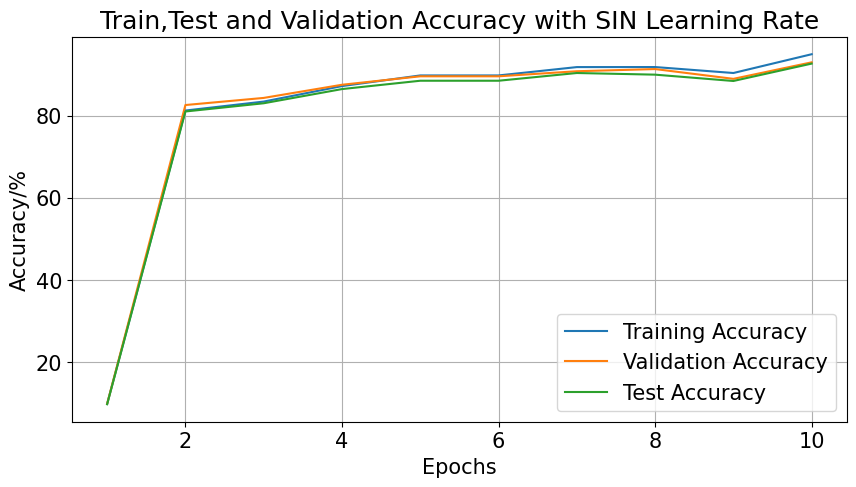

In [9]:
plt.style.use('default')
for i in range(len(val_accuracies)):
    
    plt.figure(figsize=(10,5)) #Customisable size
    plt.rcParams.update({'font.size': 15})
    plt.grid(True)
    plt.plot(epochs_range,train_accuracies[i], label = 'Training Accuracy')
    plt.plot(epochs_range,val_accuracies[i], label = 'Validation Accuracy')
    plt.plot(epochs_range,test_accuracies[i], label = 'Test Accuracy')
    plt.legend(loc='lower right')
    plt.title('Train,Test and Validation Accuracy with SIN Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/%')
    plt.show()

In [10]:
#Storing Variables
import pickle
with open("sin_model.pickle", 'wb') as f:
    pickle.dump(models, f)
with open("accuracies_sin.pickle", 'wb') as f:
    pickle.dump([val_accuracies,test_accuracies,train_accuracies], f)